In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm 
import random
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

In [71]:
df = pd.read_csv('/kaggle/input/ekbdanp/hackathon_data.csv')
df = df.drop('Unnamed: 0',axis=1)

In [72]:
def convert_to_data(raw_data):
  true_cols_names = []
  for col_first_name in [x for x in raw_data.values[0] if type(x) != float][1:]:
    if col_first_name == 'Структура численности постоянного населения на начало года (на 1 января) по возрастным группам, %':
      for procent in [x for x in raw_data.values[1] if type(x) != float]:
        for year in [2019,2020,2021,2022]:
          true_cols_names += [f'{col_first_name}/{procent}/{year}']
    else:
      for year in [2019,2020,2021,2022]:
        true_cols_names += [f'{col_first_name}/{year}']

  df = pd.DataFrame()
  df['Регион'] = raw_data.T.values[0,3:]
  for i,col in enumerate(true_cols_names):
    df[col] = raw_data.T.values[i+1,3:]
  return df

mostur_data = pd.read_excel("/kaggle/input/moisturizm-dataset/mosturism_dataset.xlsx")
mostur_data = convert_to_data(mostur_data)

/tmp/ipykernel_36/2071655665.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = raw_data.T.values[i+1,3:]
/tmp/ipykernel_36/2071655665.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = raw_data.T.values[i+1,3:]
/tmp/ipykernel_36/2071655665.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

In [73]:
### prepare data
df['all_inditifier'] = df.apply(lambda x: f'{x.policy_rk} {x.insurant_gender_cd} {x.age}',axis=1)
df['all_inditifier_cnt'] = df.groupby('all_inditifier')['policy_rk'].transform('count')
df['policy_rk_uses'] = df.groupby('policy_rk')['all_inditifier'].transform('count')
df['unique_zayavki'] = df.groupby('policy_rk')['all_inditifier'].transform('nunique')
df['premium_ratio'] = df['total_premium_amt'] / df['auto_cost']

In [74]:
### add geo feaures
features_to_merge = [
    'region',
    'region_mean_income',
    'people_count_region',
    'prestuplenia_region'
]

mostur_data = mostur_data.rename({
    'Регион':'region',
    'Среднедушевые денежные доходы населения, руб./2022': 'region_mean_income',
    'Численность постоянного населения в среднем за год, чел./2022': 'people_count_region',
    'Количество преступлений, зарегистрированных в отчетном периоде, ед./2022': 'prestuplenia_region'
},axis=1)

df = df.merge(mostur_data[features_to_merge],on='region')

In [75]:
### new features
df['prestuplenia_na_cheloveka'] = df['prestuplenia_region'] / df['people_count_region']
df['auto_in_zp'] = df['auto_cost'] / df['region_mean_income']

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'all_inditifier counts distribution'}, xlabel='paid_flg', ylabel='Count'>

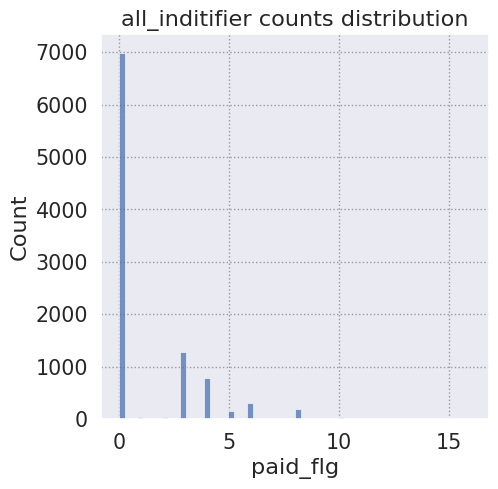

In [76]:
sns.set_style("darkgrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(5,5))
plt.title('all_inditifier counts distribution')

sns.histplot(df.groupby('policy_rk')['paid_flg'].agg('sum'))

In [77]:
## clear
df = df.loc[
    df[['auto_cost']].dropna().index
]

In [78]:
df_nunique = df.groupby('policy_rk').agg('nunique')

In [79]:
changed_cols = df_nunique.max()[df_nunique.max() != 1.0].index.tolist()
df = df.drop(changed_cols,axis=1)

In [80]:
df = df.groupby('policy_rk').agg('first')

<Figure size 640x480 with 0 Axes>

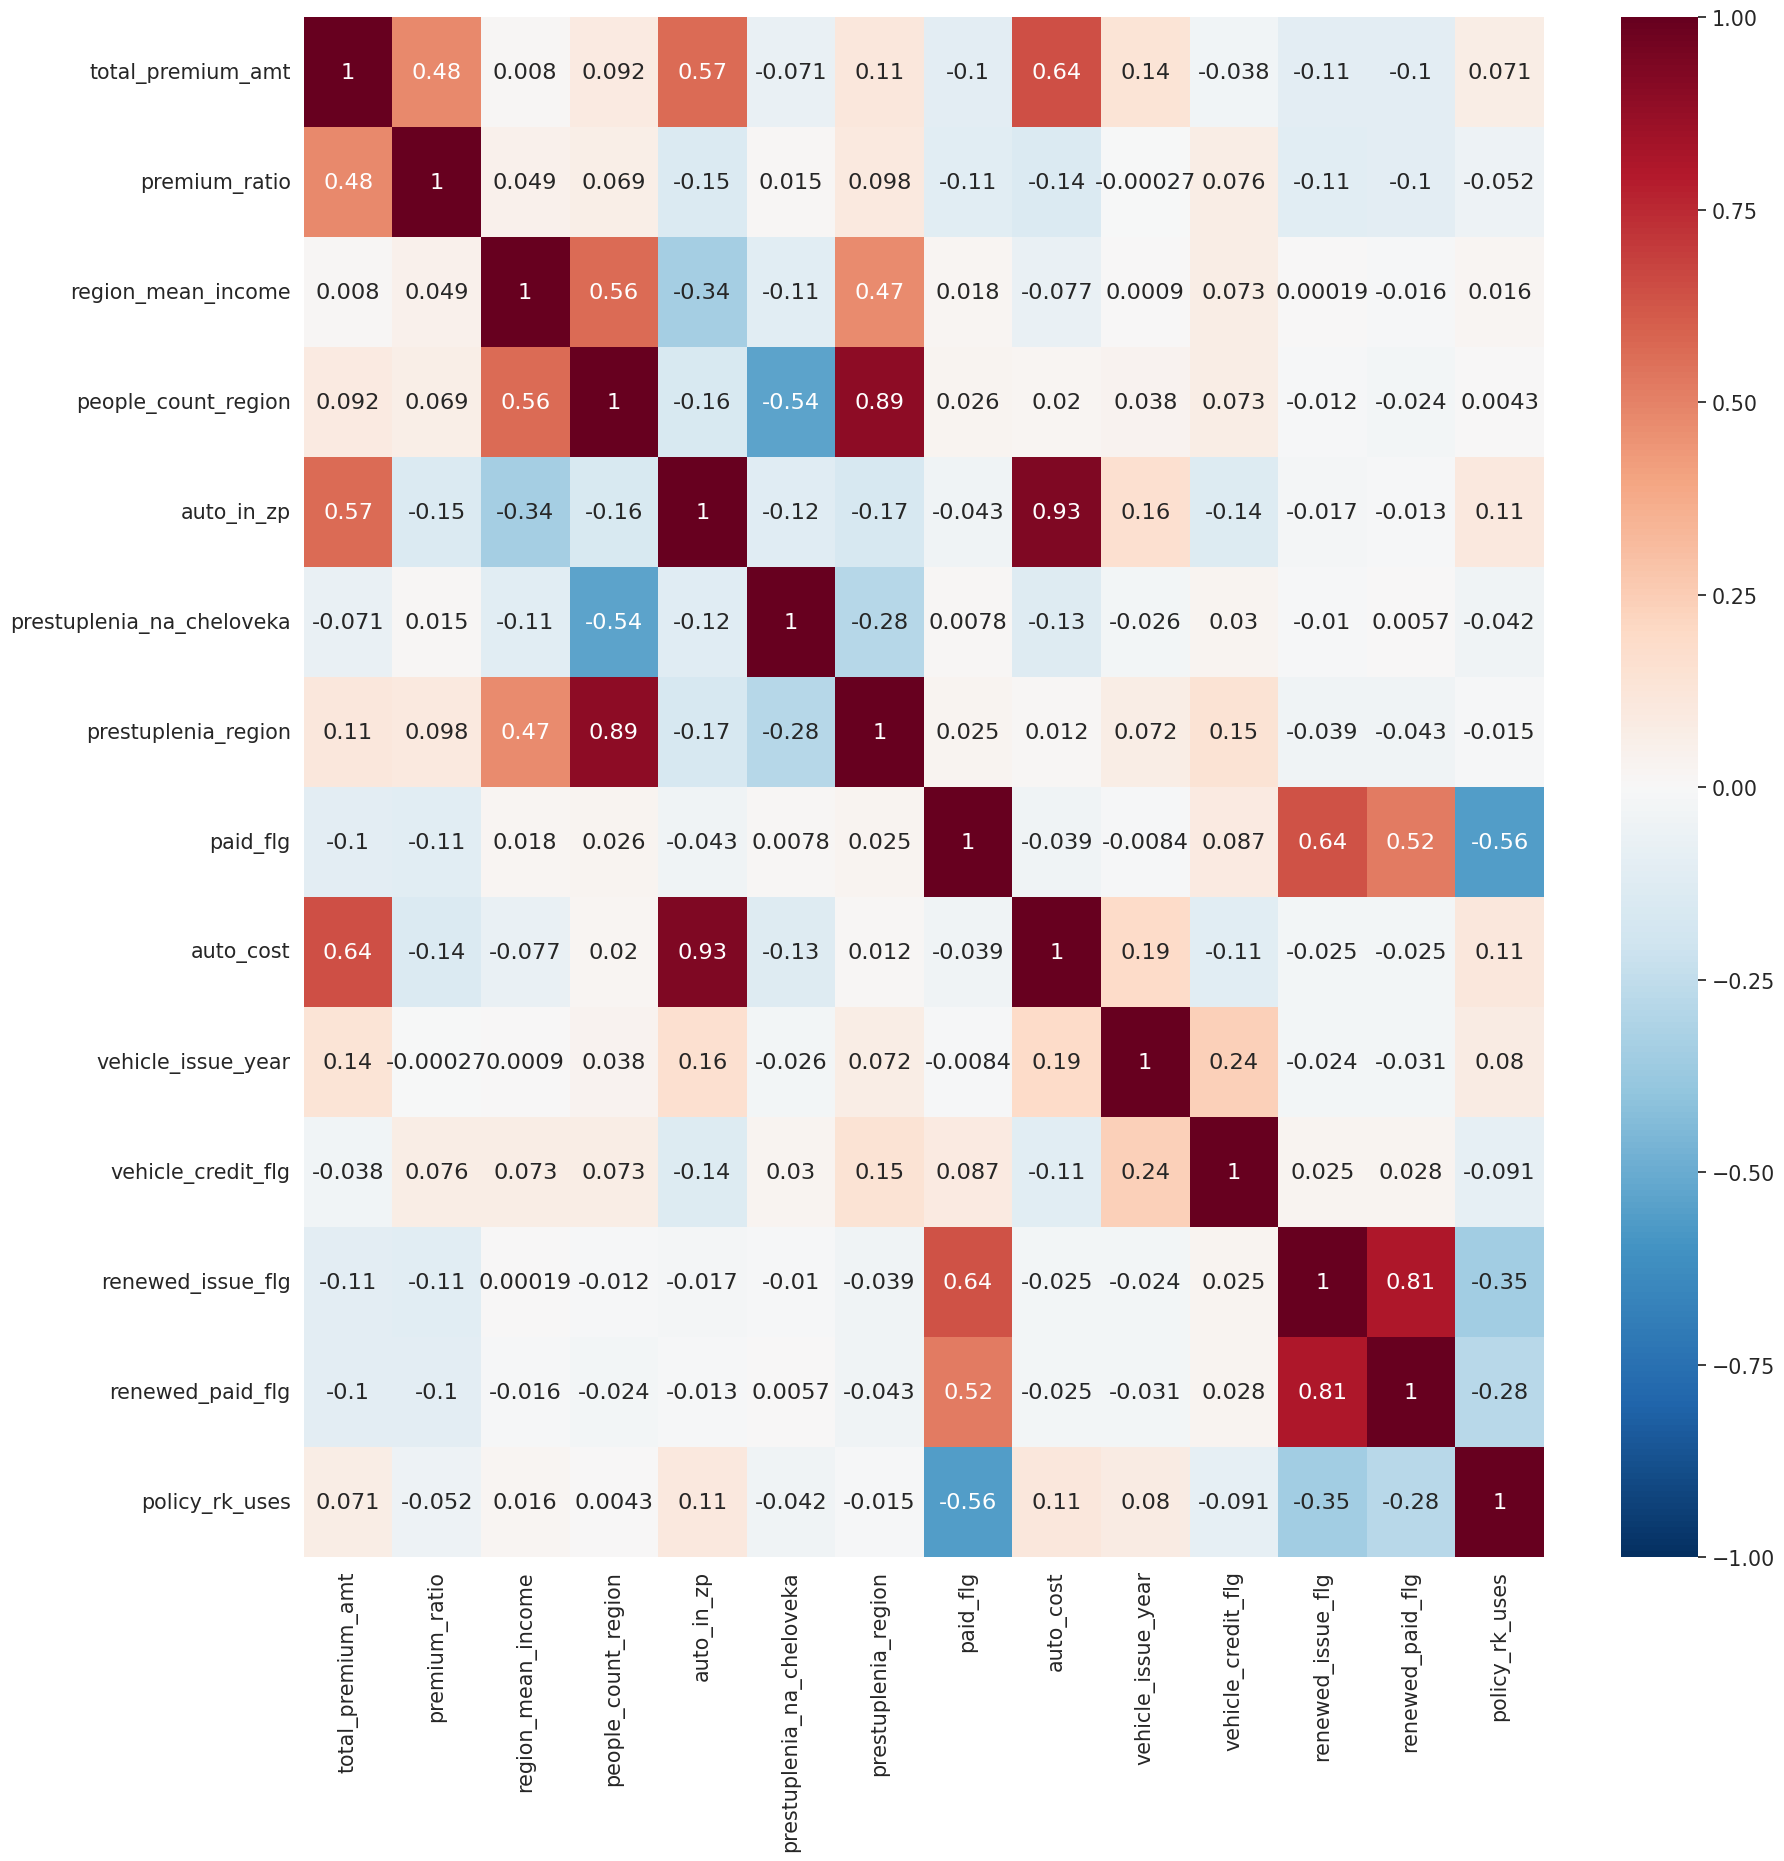

In [84]:
num_cols = [
    'total_premium_amt',
    'premium_ratio',
    'region_mean_income',
    'people_count_region',
    'auto_in_zp',
    'prestuplenia_na_cheloveka',
    'prestuplenia_region',
    'paid_flg',
    'auto_cost',
    'vehicle_issue_year',
    'vehicle_credit_flg',
    'renewed_issue_flg',
    'renewed_paid_flg',
    'policy_rk_uses',
]

sns.set(font_scale=1.35)
sns.set_style("whitegrid", {"axes.grid": False})
sns.despine()
plt.figure(figsize=(20,20))
#plt.title(2021)
sns.heatmap(
    df[num_cols].corr(),
    cmap='RdBu_r', # задаёт цветовую схему
    annot=True, # рисует значения внутри ячеек
    vmin=-1, vmax=1,); # указывает начало цветовых кодов от -1 до 1.  mask=df[num_cols].corr())

<Axes: title={'center': 'all_inditifier counts distribution'}, xlabel='auto_cost', ylabel='paid_flg'>

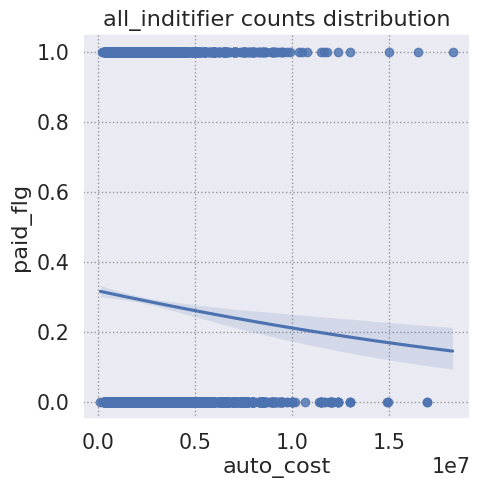

In [85]:
sns.set_style("darkgrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(5,5))
plt.title('all_inditifier counts distribution')

sns.regplot(data=df,y='paid_flg',x='auto_cost',logistic=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'auto costs dist'}, xlabel='auto_cost', ylabel='Count'>

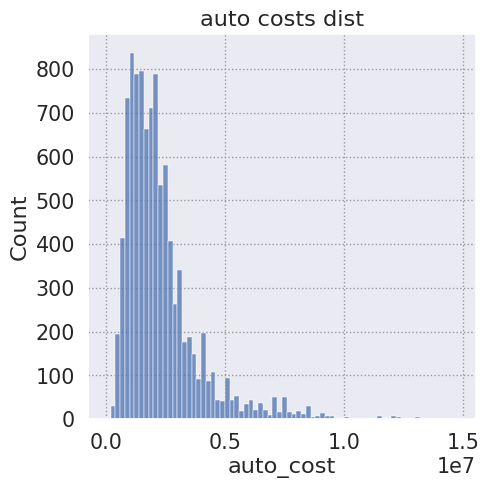

In [86]:
sns.set_style("darkgrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(5,5))
plt.title('auto costs dist')

sns.histplot(df['auto_cost'],bins=range(0,int(1.5*1e7),int(2e5)))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'auto costs dist paid_flg==0'}, xlabel='auto_cost', ylabel='Count'>

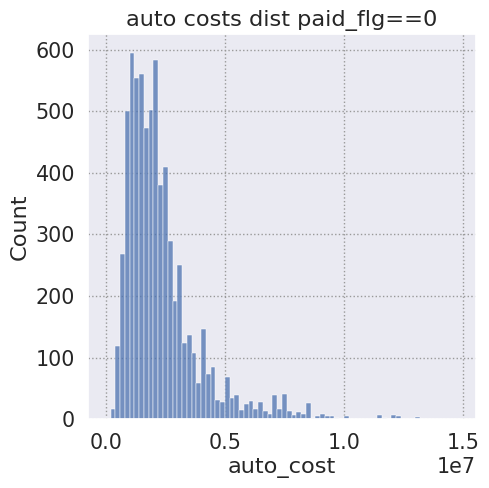

In [88]:
sns.set_style("darkgrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(5,5))
plt.title('auto costs dist paid_flg==0')

sns.histplot(df[df['paid_flg'] == 0]['auto_cost'],bins=range(0,int(1.5*1e7),int(2e5)))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'auto costs dist paid_flg==1'}, xlabel='auto_cost', ylabel='Count'>

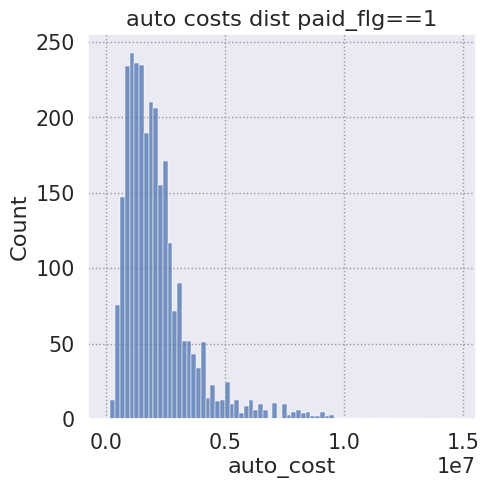

In [89]:
sns.set_style("darkgrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(5,5))
plt.title('auto costs dist paid_flg==1')

sns.histplot(df[df['paid_flg'] == 1]['auto_cost'],bins=range(0,int(1.5*1e7),int(2e5)))

In [130]:
def boostrap_means(ds,n_iters=100_000,seed=56,frac=1.0):
    means = []
    for i in trange(n_iters):
        means.append(ds.sample(frac=1.0,replace=True,random_state=seed+i).mean())
    return means

In [140]:
means_auto_costd = boostrap_means(df['auto_cost'])

  0%|          | 0/100000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'means_bostraped distr'}, ylabel='Count'>

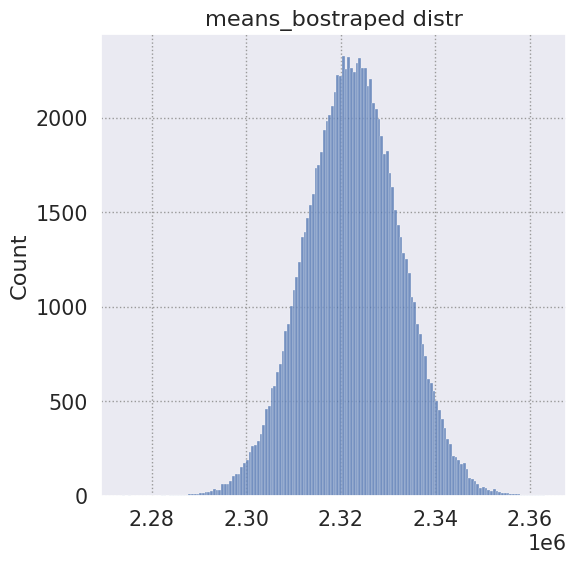

In [156]:
sns.set_style("darkgrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(6,6))
plt.title('means_bostraped distr')

sns.histplot(means_auto_costd)

In [165]:
print(
    shapiro(means_auto_costd),
    np.mean(means_auto_costd),
    np.std(means_auto_costd),
    np.percentile(means_auto_costd,2.5),
    np.percentile(means_auto_costd,97.5),
    sep='\n'
)

ShapiroResult(statistic=0.9999742657475255, pvalue=0.7499505367594042)
2322578.095082985
10005.524867071194
2303033.4116053362
2342059.9170847307


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_out(*samples, **kwds)


In [167]:
means_auto_costd_flg0 = boostrap_means(df[df['paid_flg'] == 0]['auto_cost'])

  0%|          | 0/100000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'means_bostraped distr flg == 0'}, ylabel='Count'>

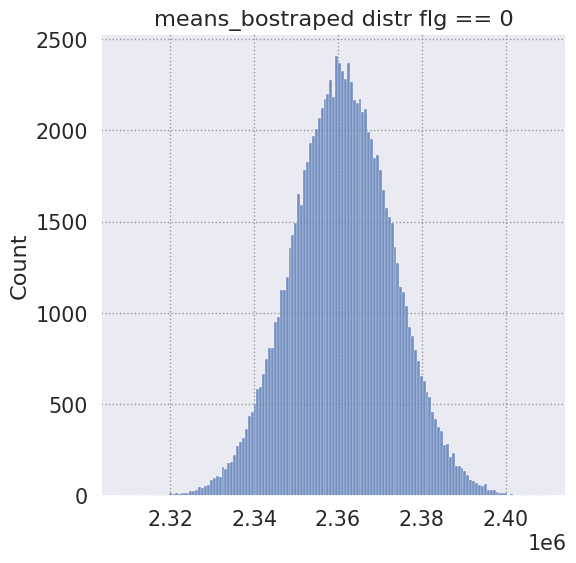

In [168]:
sns.set_style("darkgrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(6,6))
plt.title('means_bostraped distr flg == 0')

sns.histplot(means_auto_costd_flg0)

In [169]:
print(
    shapiro(means_auto_costd_flg0),
    np.mean(means_auto_costd_flg0),
    np.std(means_auto_costd_flg0),
    np.percentile(means_auto_costd_flg0,2.5),
    np.percentile(means_auto_costd_flg0,97.5),
    sep='\n'
)

ShapiroResult(statistic=0.9999799337394224, pvalue=0.9148964231066097)
2361160.737930797
12007.53691871371
2337660.5594429676
2384783.866789058


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_out(*samples, **kwds)


In [183]:
means_auto_costd_flg1 = boostrap_means(df[df['paid_flg'] == 1]['auto_cost'],n_iters=100_000,seed=56*10**5)

  0%|          | 0/100000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'means_bostraped distr flg == 1'}, ylabel='Count'>

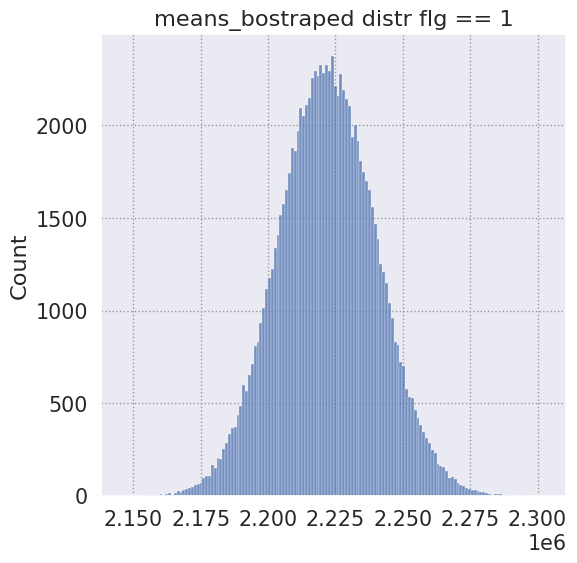

In [184]:
sns.set_style("darkgrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(6,6))
plt.title('means_bostraped distr flg == 1')

sns.histplot(means_auto_costd_flg1)

In [185]:
print(
    shapiro(means_auto_costd_flg1),
    np.mean(means_auto_costd_flg1),
    np.std(means_auto_costd_flg1),
    np.percentile(means_auto_costd_flg1,2.5),
    np.percentile(means_auto_costd_flg1,97.5),
    sep='\n'
)

ShapiroResult(statistic=0.9999407983805861, pvalue=0.04841021141727268)
2222017.27147996
18167.291740226912
2186630.065740214
2257969.945225358


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_out(*samples, **kwds)


In [189]:
levene(
    df[df['paid_flg'] == 0]['auto_cost'],
    df[df['paid_flg'] == 1]['auto_cost'],
    center='median'
)

LeveneResult(statistic=12.20697518148734, pvalue=0.0004769199915680696)

In [196]:
df[df['paid_flg'] == 0]['auto_cost'].mean(), df[df['paid_flg'] == 1]['auto_cost'].mean()

(2361123.838443117, 2221999.012704581)

In [197]:
df[df['paid_flg'] == 0]['auto_cost'].mean() - df[df['paid_flg'] == 1]['auto_cost'].mean()

139124.8257385362

In [193]:
ttest_ind(
    df[df['paid_flg'] == 0]['auto_cost'],
    df[df['paid_flg'] == 1]['auto_cost'],
    random_state=56,
    equal_var=False
)

TtestResult(statistic=6.409101384437407, pvalue=1.5121211439672312e-10, df=13586.467705132429)

In [195]:
mannwhitneyu(
    df[df['paid_flg'] == 0]['auto_cost'],
    df[df['paid_flg'] == 1]['auto_cost'],
)

MannwhitneyuResult(statistic=68333852.0, pvalue=8.04486018013358e-11)

In [90]:
def znorming(data):
    return (data - data.mean()) / data.std()
def min_max_norming(data):
    return (data - data.min()) / (data.max() - data.min())

model = sm.Logit(
    exog = sm.add_constant(df['auto_cost']),
    endog = df['paid_flg']
)

In [91]:
model = model.fit(
    #method='newton',
    #maxiter=35, 
)

Optimization terminated successfully.
         Current function value: 0.601605
         Iterations 5


In [92]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               paid_flg   No. Observations:                 9849
Model:                          Logit   Df Residuals:                     9847
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Sep 2024   Pseudo R-squ.:                0.001329
Time:                        19:50:50   Log-Likelihood:                -5925.2
converged:                       True   LL-Null:                       -5933.1
Covariance Type:            nonrobust   LLR p-value:                 7.153e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7690      0.039    -19.887      0.000      -0.845      -0.693
auto_cost  -5.506e-08   1.41e-08     -3.893      0.000   -8.28e-08   -2.73e-08
==============================================================================
"""

In [93]:
preds = model.predict(
    sm.add_constant(df['auto_cost'])
)

In [94]:
roc_auc_score(df['paid_flg'],preds)

0.5296912443249513

In [95]:
df['preds'] = preds

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='auto_cost', ylabel='paid_flg'>

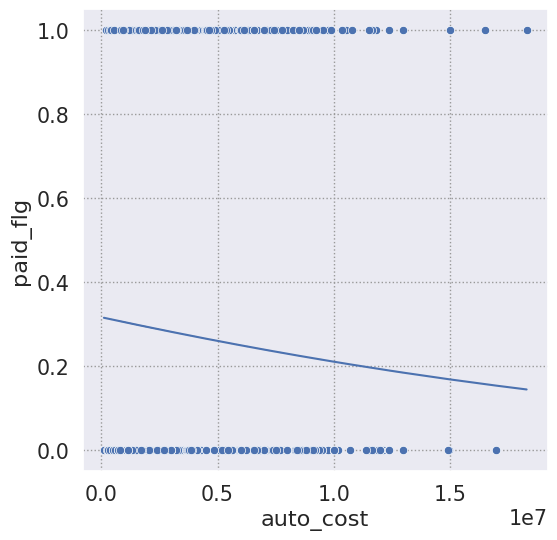

In [96]:
sns.set_style("darkgrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(6,6))

sns.scatterplot(data=df,x='auto_cost',y='paid_flg')
sns.lineplot(data=df,x='auto_cost',y='preds')

In [99]:
### one hot encode
ohe_cols = []
for s in df['coverage'].unique():
    df[f'coverage_{s}'] = df['coverage'].apply(lambda x: int(x == s))
    ohe_cols.append(f'coverage_{s}')
    
for s in df['repair_option'].unique():
    df[f'repair_option_{s}'] = df['repair_option'].apply(lambda x: int(x == s))
    ohe_cols.append(f'repair_option_{s}')

In [101]:
features = [
    'auto_cost',
    'total_premium_amt',
    'premium_ratio',
    'region_mean_income',
    'people_count_region',
    'prestuplenia_na_cheloveka',
    *ohe_cols
]

In [108]:
np.asarray(df[features])

array([[2340000.0, 787323.6, 0.3364630769230769, ..., 0, 0, 0],
       [2349551.0, 195300.0, 0.08312226463694553, ..., 0, 0, 0],
       [830000.0, 267342.21, 0.32209904819277113, ..., 0, 0, 0],
       ...,
       [2706308.0, 378000.0, 0.13967368089663112, ..., 0, 0, 0],
       [1737547.0, 127800.0, 0.07355196722736133, ..., 0, 0, 0],
       [1698387.0, 99000.0, 0.058290601612000094, ..., 0, 0, 0]],
      dtype=object)

In [110]:
model = sm.Logit(
    exog = sm.add_constant(df[features].astype(np.float64)),
    endog = df['paid_flg']
)

In [111]:
model = model.fit(
    #method='newton',
    #maxiter=35, 
)

Optimization terminated successfully.
         Current function value: 0.589495
         Iterations 7


In [112]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               paid_flg   No. Observations:                 9849
Model:                          Logit   Df Residuals:                     9837
Method:                           MLE   Df Model:                           11
Date:                Sat, 07 Sep 2024   Pseudo R-squ.:                 0.02143
Time:                        19:58:34   Log-Likelihood:                -5805.9
converged:                       True   LL-Null:                       -5933.1
Covariance Type:            nonrobust   LLR p-value:                 3.509e-48
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                             -0.3594   4.28e+07  -8.39e-09      1.000   -8.39e+07    8.39e+07
auto_cost                                                      -7.299e-08   3.27e-08     -2.235      0.025   -1.37e-07   -8.99e-09
total_premium_amt                                              -9.269e-08   1.52e-07     -0.608      0.543   -3.92e-07    2.06e-07
premium_ratio                                                     -2.0388      0.328     -6.218      0.000      -2.681      -1.396
region_mean_income                                             -1.887e-06   2.93e-06     -0.644      0.519   -7.63e-06    3.85e-06
people_count_region                                             5.191e-08   1.22e-08      4.238      0.000    2.79e-08    7.59e-08
prestuplenia_na_cheloveka                                         47.1221     15.856      2.972      0.003      16.044      78.200
coverage_Полное КАСКО                                             -0.0620        nan        nan        nan         nan         nan
coverage_Тоталь + Угон                                            -0.1454        nan        nan        nan         nan         nan
coverage_Только Угон                                              -0.0032        nan        nan        nan         nan         nan
coverage_Только ущерб                                             -0.1488        nan        nan        nan         nan         nan
repair_option_Ремонт на СТОА официального дилера                  -0.0786      1.153     -0.068      0.946      -2.339       2.181
repair_option_Ремонт на СТОА по направлению страховщика           -0.3480      0.107     -3.242      0.001      -0.558      -0.138
repair_option_Отсутствует/неизвестно                              -0.0032        nan        nan        nan         nan         nan
repair_option_Эконом ремонт на СТОА по направлению Страховщика     0.0704         -0       -inf      0.000       0.070       0.070
==================================================================================================================================
"""

In [113]:
preds = model.predict(
     sm.add_constant(df[features].astype(np.float64)),
)

In [117]:
roc_auc_score(df['paid_flg'],preds)

0.5934572499263175

In [118]:
df['preds_full'] = preds

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='auto_cost', ylabel='paid_flg'>

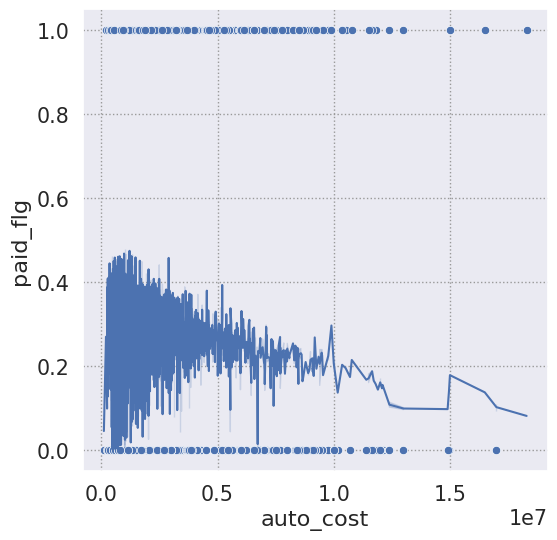

In [121]:
sns.set_style("darkgrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(6,6))

sns.scatterplot(data=df,x='auto_cost',y='paid_flg')
sns.lineplot(data=df,x='auto_cost',y='preds_full')

<Axes: xlabel='auto_cost', ylabel='preds_full'>

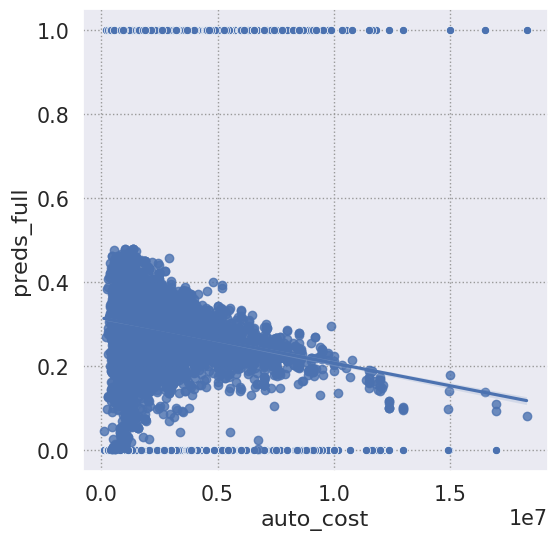

In [122]:
sns.set_style("darkgrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(6,6))

sns.scatterplot(data=df,x='auto_cost',y='paid_flg')
sns.regplot(data=df,x='auto_cost',y='preds_full')

In [124]:
### chek freq paid_flg per auto_cost median
df[
    df['auto_cost'] >= df['auto_cost'].median()
]['paid_flg'].mean()

0.273254650930186

In [125]:
df[
    df['auto_cost'] < df['auto_cost'].median()
]['paid_flg'].mean()

0.30783505154639174

In [126]:
mannwhitneyu(
    df[df['auto_cost'] <= df['auto_cost'].median()]['paid_flg'],
    df[df['auto_cost'] > df['auto_cost'].median()]['paid_flg'],
)

MannwhitneyuResult(statistic=12557959.0, pvalue=9.452539470681207e-05)

In [127]:
levene(
    df[df['auto_cost'] <= df['auto_cost'].median()]['paid_flg'],
    df[df['auto_cost'] > df['auto_cost'].median()]['paid_flg'],
    center='median'
)

LeveneResult(statistic=15.265136322130775, pvalue=9.405009517094238e-05)

In [128]:
ttest_ind(
    df[df['auto_cost'] <= df['auto_cost'].median()]['paid_flg'],
    df[df['auto_cost'] > df['auto_cost'].median()]['paid_flg'],
    random_state=56,
    equal_var=False
)

TtestResult(statistic=3.9079153776009807, pvalue=9.371963504853123e-05, df=9841.110749530122)

In [135]:
### chek with mean_income_per_region
all_bostrap_mean_income = boostrap_means(df['region_mean_income'])
all_bostrap_mean_income_0 = boostrap_means(df[df['paid_flg'] == 0]['region_mean_income'])
all_bostrap_mean_income_1 = boostrap_means(df[df['paid_flg'] == 1]['region_mean_income'])

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [136]:
shapiro(all_bostrap_mean_income), shapiro(all_bostrap_mean_income_0), shapiro(all_bostrap_mean_income_1)

(ShapiroResult(statistic=0.9999598375715363, pvalue=0.2833000406225732),
 ShapiroResult(statistic=0.9999697258488244, pvalue=0.586680709928695),
 ShapiroResult(statistic=0.9999559982136197, pvalue=0.20357324687865536))

In [143]:
mannwhitneyu(
    df[df['paid_flg'] == 0]['region_mean_income'].astype(np.float64),
    df[df['paid_flg'] == 1]['region_mean_income'].astype(np.float64)
)

MannwhitneyuResult(statistic=9692258.0, pvalue=0.018661284738897374)

In [137]:
levene(
    df[df['paid_flg'] == 0]['region_mean_income'],
    df[df['paid_flg'] == 1]['region_mean_income'],
    center='median'
)

LeveneResult(statistic=1.963747906380086, pvalue=0.16114456891252663)

In [147]:
ttest_ind(
    df[df['paid_flg'] == 0]['region_mean_income'].astype(np.float64),
    df[df['paid_flg'] == 1]['region_mean_income'].astype(np.float64),
    random_state=56,
    equal_var=True
)

TtestResult(statistic=-1.779436342748853, pvalue=0.0751990879076837, df=9847.0)